In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample


In [2]:
dg10 = xr.open_dataset("/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc")
lat_rho_10 = dg10.variables["lat_rho"]
lon_rho_10 = dg10.variables["lon_rho"]
zice_10 = dg10.variables["zice"]
h_10 = dg10.variables["h"]
dg10.close()

dg4 = xr.open_dataset("/scratch/project_2000789/boeiradi/waom4_frc/waom4extend_grd.nc")
lat_rho_4 = dg4.variables["lat_rho"]
lon_rho_4 = dg4.variables["lon_rho"]
zice_4 = dg4.variables["zice"]
h_4 = dg4.variables["h"]
dg4.close()

dg4c = xr.open_dataset("/scratch/project_2000789/boeiradi/waom4_frc/waom4extend_grd_10km-bathym.nc")
lat_rho_4c = dg4c.variables["lat_rho"]
lon_rho_4c = dg4c.variables["lon_rho"]
zice_4c = dg4c.variables["zice"]
h_4c = dg4c.variables["h"]
dg4c.close()

dg2 = xr.open_dataset("/scratch/project_2000339/boeiradi/waom2_frc/waom2extend_grd.nc")
lat_rho_2 = dg2.variables["lat_rho"]
lon_rho_2 = dg2.variables["lon_rho"]
zice_2 = dg2.variables["zice"]
h_2 = dg2.variables["h"]
dg2.close()



In [3]:
# read bottom temperature and currents from annual, 10km-interpolated netcdf file:
# --- created with /users/boeiradi/COLD_project/postprocessing/waom_notebook/Maps_validations/WAOM10x4x2extend_shflim_S_0.25Q_TSVel_botXsfc.py

dt = xr.open_dataset('/scratch/project_2000339/boeiradi/waom10extend_shflim_S_0.25Q/output_20yr_diag/WAOM10x4x2_Annual_bottom_temp_UV_maps.nc')
temp_ann_bot_10 = np.squeeze(dt.variables['temp_ann_bot_10'])
temp_ann_bot_4 = np.squeeze(dt.variables['temp_ann_bot_4'])
temp_ann_bot_4nt = np.squeeze(dt.variables['temp_ann_bot_4nt'])
temp_ann_bot_4c = np.squeeze(dt.variables['temp_ann_bot_4c'])
temp_ann_bot_2 = np.squeeze(dt.variables['temp_ann_bot_2'])

# temp_ann_sfc_4c
temp_ann_sfc_10 = np.squeeze(dt.variables['temp_ann_sfc_10'])
temp_ann_sfc_4 = np.squeeze(dt.variables['temp_ann_sfc_4'])
temp_ann_sfc_4nt = np.squeeze(dt.variables['temp_ann_sfc_4nt'])
temp_ann_sfc_4c = np.squeeze(dt.variables['temp_ann_sfc_4c'])
# temp_ann_sfc_2 = np.squeeze(dt.variables['temp_ann_sfc_2'])

salt_ann_bot_10 = np.squeeze(dt.variables['salt_ann_bot_10'])
salt_ann_bot_4 = np.squeeze(dt.variables['salt_ann_bot_4'])
salt_ann_bot_4nt = np.squeeze(dt.variables['salt_ann_bot_4nt'])
salt_ann_bot_4c = np.squeeze(dt.variables['salt_ann_bot_4c'])
salt_ann_bot_2 = np.squeeze(dt.variables['salt_ann_bot_2'])

u_10_bot = np.squeeze(dt.variables['u_10_bot'])
v_10_bot = np.squeeze(dt.variables['v_10_bot'])
u_4_bot = np.squeeze(dt.variables['u_4_bot'])
v_4_bot = np.squeeze(dt.variables['v_4_bot'])
u_4nt_bot = np.squeeze(dt.variables['u_4nt_bot'])
v_4nt_bot = np.squeeze(dt.variables['v_4nt_bot'])
u_4c_bot = np.squeeze(dt.variables['u_4c_bot'])
v_4c_bot = np.squeeze(dt.variables['v_4c_bot'])
u_2_bot = np.squeeze(dt.variables['u_2_bot'])
v_2_bot = np.squeeze(dt.variables['v_2_bot'])

xs_10 = np.squeeze(dt.variables['xs_10'])
ys_10 = np.squeeze(dt.variables['ys_10'])
xs_4 = np.squeeze(dt.variables['xs_4'])
ys_4 = np.squeeze(dt.variables['ys_4'])
xs_2 = np.squeeze(dt.variables['xs_2'])
ys_2 = np.squeeze(dt.variables['ys_2'])

# z_rho_bot_10 = np.squeeze(dt.variables['z_rho_10_bot'])
# z_rho_bot_4 = np.squeeze(dt.variables['z_rho_4_bot'])
# z_rho_bot_2 = np.squeeze(dt.variables['z_rho_2_bot'])

Tf_bot_10 = np.squeeze(dt.variables['Tf_10_bot'])
Tf_bot_4 = np.squeeze(dt.variables['Tf_4_bot'])
Tf_bot_2 = np.squeeze(dt.variables['Tf_2_bot'])
Tf_sfc_10 = np.squeeze(dt.variables['Tf_10_sfc'])
Tf_sfc_4 = np.squeeze(dt.variables['Tf_4_sfc'])
Tf_sfc_2 = np.squeeze(dt.variables['Tf_2_sfc'])

Tf_sfc_4nt = np.squeeze(dt.variables['Tf_4A_sfc'])
Tf_bot_4nt = np.squeeze(dt.variables['Tf_4A_bot'])
Tf_sfc_4c = np.squeeze(dt.variables['Tf_4B_sfc'])
Tf_bot_4c = np.squeeze(dt.variables['Tf_4B_bot'])

dt.close()


In [18]:
# re-grid high-res zice/h to 10km grid:
w10_def = pyresample.geometry.SwathDefinition(lons=lon_rho_10,lats=lat_rho_10)
w4_def = pyresample.geometry.SwathDefinition(lons=lon_rho_4,lats=lat_rho_4)
w2_def = pyresample.geometry.SwathDefinition(lons=lon_rho_2,lats=lat_rho_2)

wf = lambda r: 1/r

zice_4_interp = pyresample.kd_tree.resample_custom(w4_def,zice_4.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)
zice_2_interp = pyresample.kd_tree.resample_custom(w2_def,zice_2.values,w10_def,\
                                         radius_of_influence=5000,neighbours=1,weight_funcs=wf)
zice_4c_interp = pyresample.kd_tree.resample_custom(w4_def,zice_4c.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)

Tf_sfc_4_interp = pyresample.kd_tree.resample_custom(w4_def,Tf_sfc_4.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)

Tf_sfc_2_interp = pyresample.kd_tree.resample_custom(w2_def,Tf_sfc_2.values,w10_def,\
                                         radius_of_influence=5000,neighbours=1,weight_funcs=wf)

Tf_sfc_4c_interp = pyresample.kd_tree.resample_custom(w4_def,Tf_sfc_4c.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)

Tf_bot_4_interp = pyresample.kd_tree.resample_custom(w4_def,Tf_bot_4.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)

Tf_bot_2_interp = pyresample.kd_tree.resample_custom(w2_def,Tf_bot_2.values,w10_def,\
                                         radius_of_influence=5000,neighbours=1,weight_funcs=wf)

Tf_bot_4c_interp = pyresample.kd_tree.resample_custom(w4_def,Tf_bot_4c.values,w10_def,\
                                         radius_of_influence=30000,neighbours=4,weight_funcs=wf)


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 4 neighbours within 30000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


In [9]:
# figures
fig_path = '/users/boeiradi/COLD_project/postprocessing/figs/Maps_validations/'

### plot maps
import matplotlib.path as mpath
import cartopy.feature as cfeature

def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray')
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray')
    # longitude labels
    ax.text(0,-66,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(60,-53,'60$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(120,-53,'120$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-60,-48,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-120,-48,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray')
    ax.text(180,-60,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray')
    return

proj = ccrs.SouthPolarStereo()


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.a

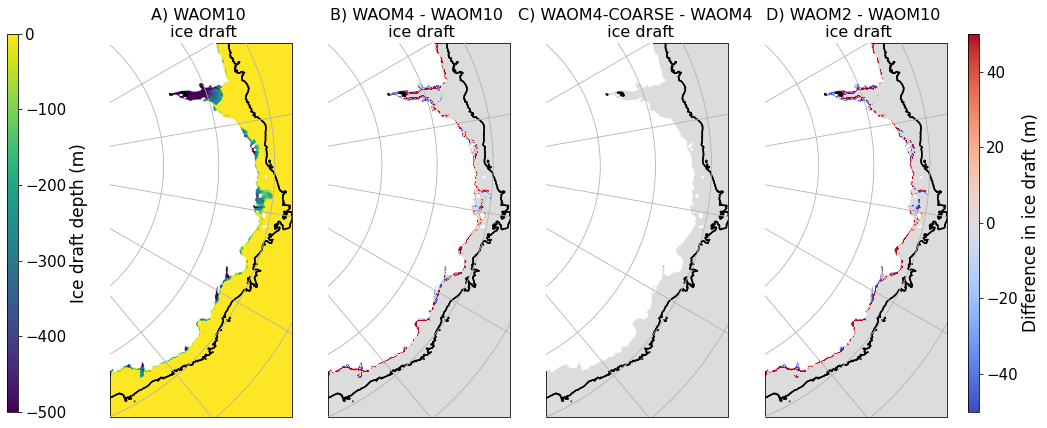

In [6]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(1,4,1, projection=proj)
plt.title('A) WAOM10 \n ice draft', fontsize=16)
cy=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_10, transform=ccrs.PlateCarree(), vmin=-500, vmax=0)
ax0.gridlines(zorder=4)
ax0.set_extent([65, 150, -70, -63.5], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)


ax1 = fig.add_subplot(1,4,2, projection=proj)
plt.title('B) WAOM4 - WAOM10 \n ice draft', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
ax1.gridlines(zorder=4)
ax1.set_extent([65, 150, -70, -63.5], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(1,4,3, projection=proj)
plt.title('C) WAOM4-COARSE - WAOM4 \n ice draft', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4c_interp-zice_4_interp, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
ax2.gridlines(zorder=4)
ax2.set_extent([65, 150, -70, -63.5], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax3 = fig.add_subplot(1,4,4, projection=proj)
plt.title('D) WAOM2 - WAOM10 \n ice draft', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_2_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
ax3.gridlines(zorder=4)
ax3.set_extent([65, 150, -70, -63.5], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

cbar_ax0 = fig.add_axes([0.03, 0.25, 0.01, 0.525])
fig.colorbar(cy, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Ice draft depth (m)', fontsize=17)#, labelpad=-35)
cbar_ax0.tick_params(labelsize=15)

cbar_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.525])
fig.colorbar(cya, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Difference in ice draft (m)', fontsize=17)#, labelpad=-35)
cbar_ax1.tick_params(labelsize=15)

name_fig="waom10x4x4cx2_ice_draft_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300)
plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8

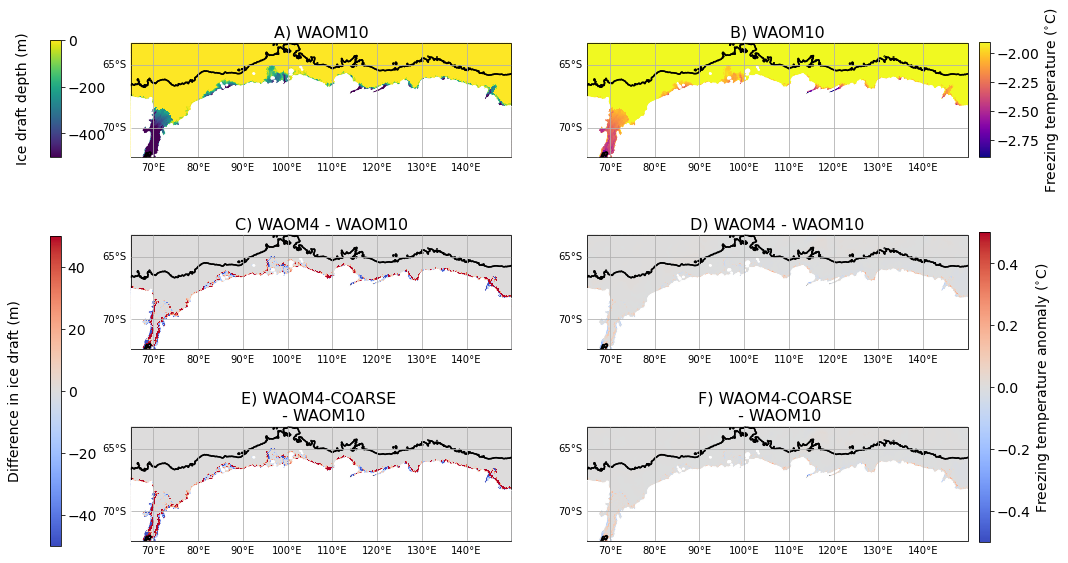

In [16]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

# DIFFERENCE IN FREEZING TEMPERATURE ONLY (at surface layer)
proj = ccrs.Mercator()
ratio = .3

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(3,2,1, projection=proj)
plt.title('A) WAOM10', fontsize=16)
cy=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_10, transform=ccrs.PlateCarree(), vmin=-500, vmax=0)
gl = ax0.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax0.get_xlim()
y_low, y_high = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax1 = fig.add_subplot(3,2,3, projection=proj)
plt.title('C) WAOM4 - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(3,2,5, projection=proj)
plt.title('E) WAOM4-COARSE \n - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4c_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

# set colorbar
cbar_ax0 = fig.add_axes([0.05, 0.69, 0.01, 0.1625])
fig.colorbar(cy, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Ice draft depth (m)', fontsize=14, labelpad=-90)
cbar_ax0.tick_params(labelsize=14)

# set colorbar diff
cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.43])
fig.colorbar(cya, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Difference in ice draft (m)', fontsize=14, labelpad=-90)
cbar_ax1.tick_params(labelsize=14)

ax4 = fig.add_subplot(3,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-2.9, vmax=-1.9)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('B) WAOM10', fontsize=16)

ax5 = fig.add_subplot(3,2,4, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_sfc_4_interp - Tf_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax5.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax5.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('D) WAOM4 - WAOM10', fontsize=16)

ax6 = fig.add_subplot(3,2,6, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_sfc_4c_interp - Tf_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('F) WAOM4-COARSE \n - WAOM10', fontsize=16)

## set colorbar
cbar_ax2 = fig.add_axes([0.91, 0.69, 0.01, 0.16])
fig.colorbar(ctf, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Freezing temperature ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax2.tick_params(labelsize=14)

cbar_ax3 = fig.add_axes([0.91, 0.155, 0.01, 0.43])
fig.colorbar(ctfa, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('Freezing temperature anomaly ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax3.tick_params(labelsize=14)

name_fig="waom10x4x4c_icedraft_Tf_sfc_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300, bbox='tight')
plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8

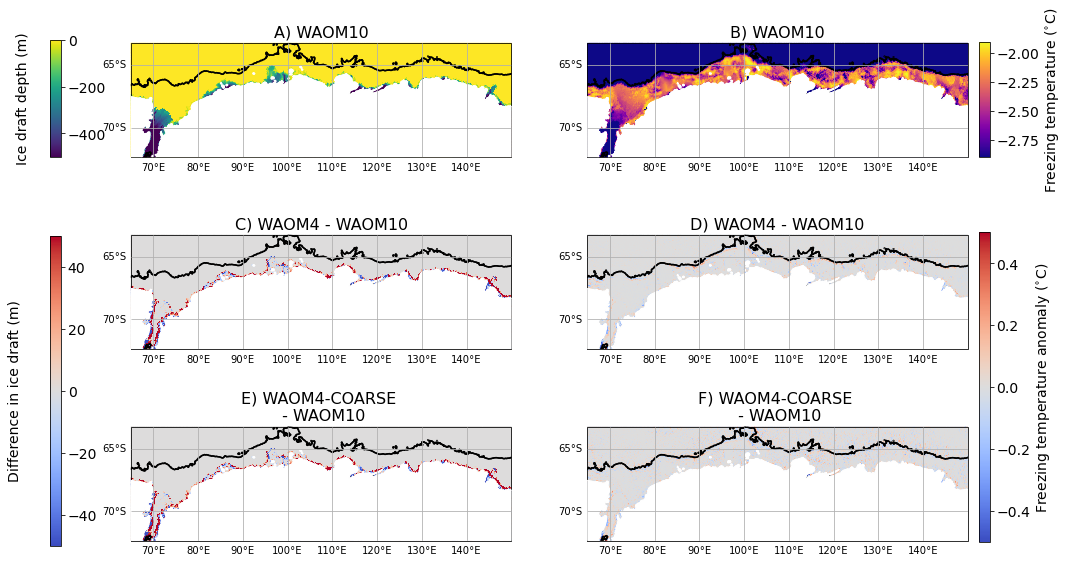

In [15]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

# DIFFERENCE IN FREEZING TEMPERATURE ONLY (at bottom layer)
proj = ccrs.Mercator()
ratio = .3

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(3,2,1, projection=proj)
plt.title('A) WAOM10', fontsize=16)
cy=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_10, transform=ccrs.PlateCarree(), vmin=-500, vmax=0)
gl = ax0.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax0.get_xlim()
y_low, y_high = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax1 = fig.add_subplot(3,2,3, projection=proj)
plt.title('C) WAOM4 - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(3,2,5, projection=proj)
plt.title('E) WAOM4-COARSE \n - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4c_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

# set colorbar
cbar_ax0 = fig.add_axes([0.05, 0.69, 0.01, 0.1625])
fig.colorbar(cy, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Ice draft depth (m)', fontsize=14, labelpad=-90)
cbar_ax0.tick_params(labelsize=14)

# set colorbar diff
cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.43])
fig.colorbar(cya, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Difference in ice draft (m)', fontsize=14, labelpad=-90)
cbar_ax1.tick_params(labelsize=14)

ax4 = fig.add_subplot(3,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-2.9, vmax=-1.9)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('B) WAOM10', fontsize=16)

ax5 = fig.add_subplot(3,2,4, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_bot_4_interp - Tf_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax5.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax5.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('D) WAOM4 - WAOM10', fontsize=16)

ax6 = fig.add_subplot(3,2,6, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_bot_4c_interp - Tf_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('F) WAOM4-COARSE \n - WAOM10', fontsize=16)

## set colorbar
cbar_ax2 = fig.add_axes([0.91, 0.69, 0.01, 0.16])
fig.colorbar(ctf, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Freezing temperature ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax2.tick_params(labelsize=14)

cbar_ax3 = fig.add_axes([0.91, 0.155, 0.01, 0.43])
fig.colorbar(ctfa, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('Freezing temperature anomaly ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax3.tick_params(labelsize=14)

name_fig="waom10x4x4c_icedraft_Tf_bot_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300, bbox='tight')
plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8

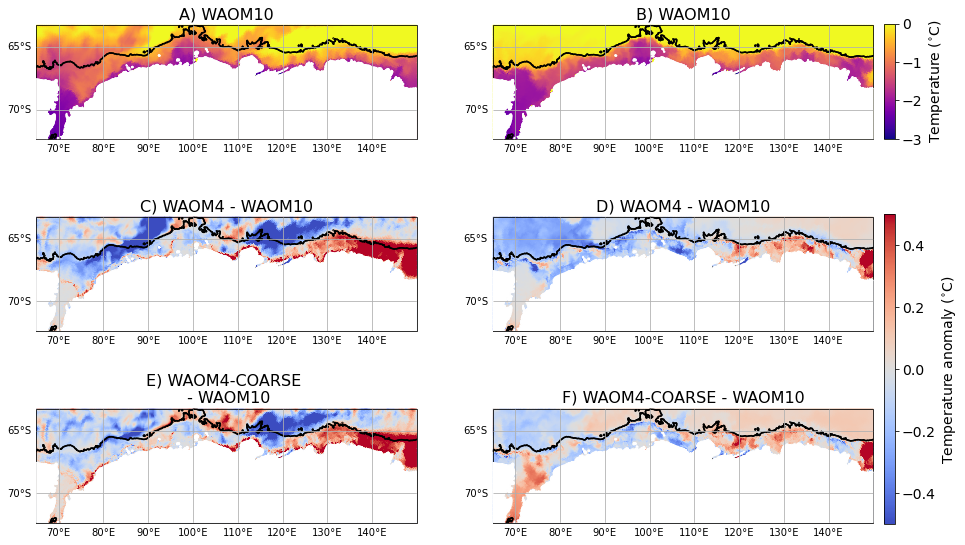

In [13]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

proj = ccrs.Mercator()
ratio = .3

# 24.12.2022
# - for thermal forcing comparison b/w resolution, we need to use the same model temp. (e.g. WAOM10) to calculate the
# thermal forcing in a way to see the effect on the freezing temperature. 
# If used each model own temperature (sfc), it shows differences that are related with ocean near-temperature field; 

# DIFFERENCE in surface and bottom temperature

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(3,2,1, projection=proj)
plt.title('A) WAOM10', fontsize=16)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-3, vmax=0)
gl = ax0.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax0.get_xlim()
y_low, y_high = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax1 = fig.add_subplot(3,2,3, projection=proj)
plt.title('C) WAOM4 - WAOM10', fontsize=16)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_sfc_4 - temp_ann_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(3,2,5, projection=proj)
plt.title('E) WAOM4-COARSE \n - WAOM10', fontsize=16)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_sfc_4c - temp_ann_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

# set colorbar
# cbar_ax0 = fig.add_axes([0.05, 0.69, 0.01, 0.1625])
# fig.colorbar(cy, cax=cbar_ax0, orientation='vertical')
# cbar_ax0.set_ylabel('Ice draft depth (m)', fontsize=14, labelpad=-90)
# cbar_ax0.tick_params(labelsize=14)

# # set colorbar diff
# cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.43])
# fig.colorbar(cya, cax=cbar_ax1, orientation='vertical')
# cbar_ax1.set_ylabel('Difference in ice draft (m)', fontsize=14, labelpad=-90)
# cbar_ax1.tick_params(labelsize=14)

ax4 = fig.add_subplot(3,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-3, vmax=0)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('B) WAOM10', fontsize=16)

ax5 = fig.add_subplot(3,2,4, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_4 - temp_ann_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax5.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax5.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('D) WAOM4 - WAOM10', fontsize=16)

ax6 = fig.add_subplot(3,2,6, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_4c - temp_ann_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('F) WAOM4-COARSE - WAOM10', fontsize=16)

## set colorbar
cbar_ax2 = fig.add_axes([0.91, 0.69, 0.01, 0.16])
fig.colorbar(ctf, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Temperature ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax2.tick_params(labelsize=14)

cbar_ax3 = fig.add_axes([0.91, 0.155, 0.01, 0.43])
fig.colorbar(ctfa, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('Temperature anomaly ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax3.tick_params(labelsize=14)

name_fig="waom10x4x4c_temp_botXsfc_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300, bbox='tight')
plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8

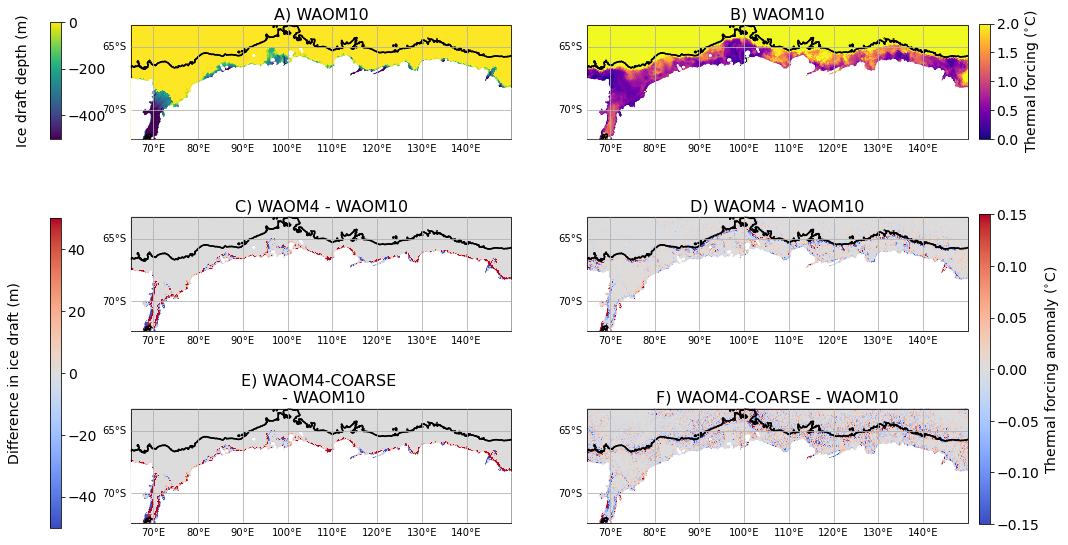

In [17]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

proj = ccrs.Mercator()
ratio = .3

# 24.12.2022
# - for thermal forcing comparison b/w resolution, we need to use the same model temp. (e.g. WAOM10) to calculate the
# thermal forcing in a way to see the effect on the freezing temperature. 
# If used each model own temperature (sfc), it shows differences that are related with ocean near-temperature field; 

# DIFFERENCE in surface thermal forcing

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(3,2,1, projection=proj)
plt.title('A) WAOM10', fontsize=16)
cy=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_10, transform=ccrs.PlateCarree(), vmin=-500, vmax=0)
gl = ax0.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax0.get_xlim()
y_low, y_high = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax1 = fig.add_subplot(3,2,3, projection=proj)
plt.title('C) WAOM4 - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(3,2,5, projection=proj)
plt.title('E) WAOM4-COARSE \n - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4c_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

# set colorbar
cbar_ax0 = fig.add_axes([0.05, 0.69, 0.01, 0.1625])
fig.colorbar(cy, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Ice draft depth (m)', fontsize=14, labelpad=-90)
cbar_ax0.tick_params(labelsize=14)

# set colorbar diff
cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.43])
fig.colorbar(cya, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Difference in ice draft (m)', fontsize=14, labelpad=-90)
cbar_ax1.tick_params(labelsize=14)

ax4 = fig.add_subplot(3,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_10 - Tf_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=0, vmax=2)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('B) WAOM10', fontsize=16)

ax5 = fig.add_subplot(3,2,4, projection=proj)
# ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_4-Tf_bot_4_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_10-Tf_bot_4_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax5.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax5.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('D) WAOM4 - WAOM10', fontsize=16)

ax6 = fig.add_subplot(3,2,6, projection=proj)
# ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_4c - Tf_bot_4c_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_10 - Tf_bot_4c_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('F) WAOM4-COARSE - WAOM10', fontsize=16)

## set colorbar
cbar_ax2 = fig.add_axes([0.91, 0.69, 0.01, 0.16])
fig.colorbar(ctf, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Thermal forcing ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax2.tick_params(labelsize=14)

cbar_ax3 = fig.add_axes([0.91, 0.155, 0.01, 0.43])
fig.colorbar(ctfa, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('Thermal forcing anomaly ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax3.tick_params(labelsize=14)

name_fig="waom10x4x4c_icedraft_thermalfrc_bot_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300, bbox='tight')
plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8

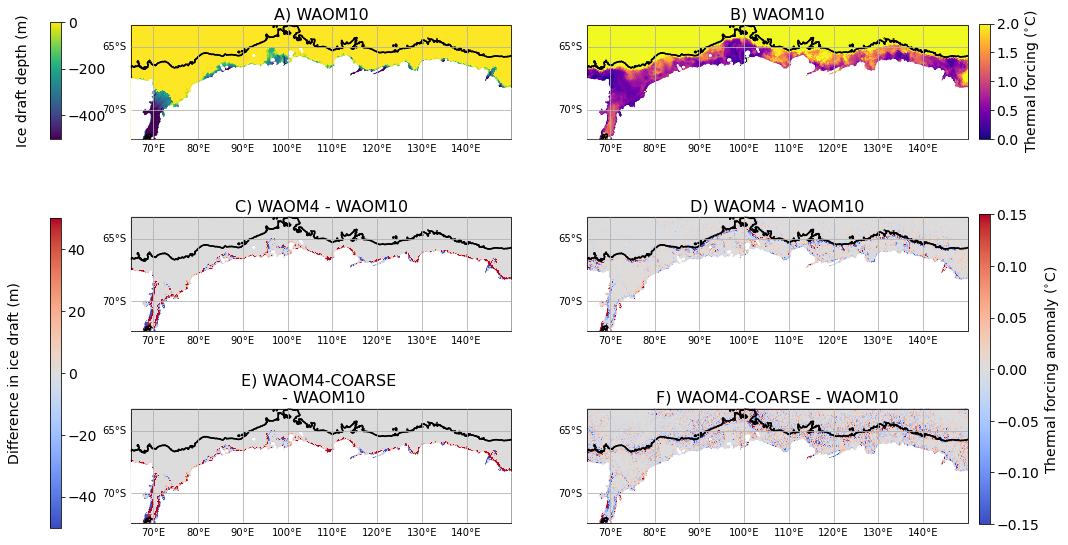

In [19]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

proj = ccrs.Mercator()
ratio = .3

# 24.12.2022
# - for thermal forcing comparison b/w resolution, we need to use the same model temp. (e.g. WAOM10) to calculate the
# thermal forcing in a way to see the effect on the freezing temperature. 
# If used each model own temperature (sfc), it shows differences that are related with ocean near-temperature field; 

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(3,2,1, projection=proj)
plt.title('A) WAOM10', fontsize=16)
cy=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_10, transform=ccrs.PlateCarree(), vmin=-500, vmax=0)
gl = ax0.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax0.get_xlim()
y_low, y_high = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax1 = fig.add_subplot(3,2,3, projection=proj)
plt.title('C) WAOM4 - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(3,2,5, projection=proj)
plt.title('E) WAOM4-COARSE \n - WAOM10', fontsize=16)
cya=plt.pcolormesh(lon_rho_10,lat_rho_10,zice_4c_interp-zice_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-50, vmax=50)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

# set colorbar
cbar_ax0 = fig.add_axes([0.05, 0.69, 0.01, 0.1625])
fig.colorbar(cy, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Ice draft depth (m)', fontsize=14, labelpad=-90)
cbar_ax0.tick_params(labelsize=14)

# set colorbar diff
cbar_ax1 = fig.add_axes([0.05, 0.15, 0.01, 0.43])
fig.colorbar(cya, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Difference in ice draft (m)', fontsize=14, labelpad=-90)
cbar_ax1.tick_params(labelsize=14)

ax4 = fig.add_subplot(3,2,2, projection=proj)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_10 - Tf_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=0, vmax=2)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('B) WAOM10', fontsize=16)

ax5 = fig.add_subplot(3,2,4, projection=proj)
# ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_4-Tf_bot_4_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_10-Tf_bot_4_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax5.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax5.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('D) WAOM4 - WAOM10', fontsize=16)

ax6 = fig.add_subplot(3,2,6, projection=proj)
# ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_4c - Tf_bot_4c_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_bot_10 - Tf_bot_4c_interp)-(temp_ann_bot_10 - Tf_bot_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.15, vmax=.15)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('F) WAOM4-COARSE - WAOM10', fontsize=16)

## set colorbar
cbar_ax2 = fig.add_axes([0.91, 0.69, 0.01, 0.16])
fig.colorbar(ctf, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Thermal forcing ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax2.tick_params(labelsize=14)

cbar_ax3 = fig.add_axes([0.91, 0.155, 0.01, 0.43])
fig.colorbar(ctfa, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('Thermal forcing anomaly ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax3.tick_params(labelsize=14)

name_fig="waom10x4x4c_icedraft_thermalfrc_bot_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300, bbox='tight')
plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. Thi

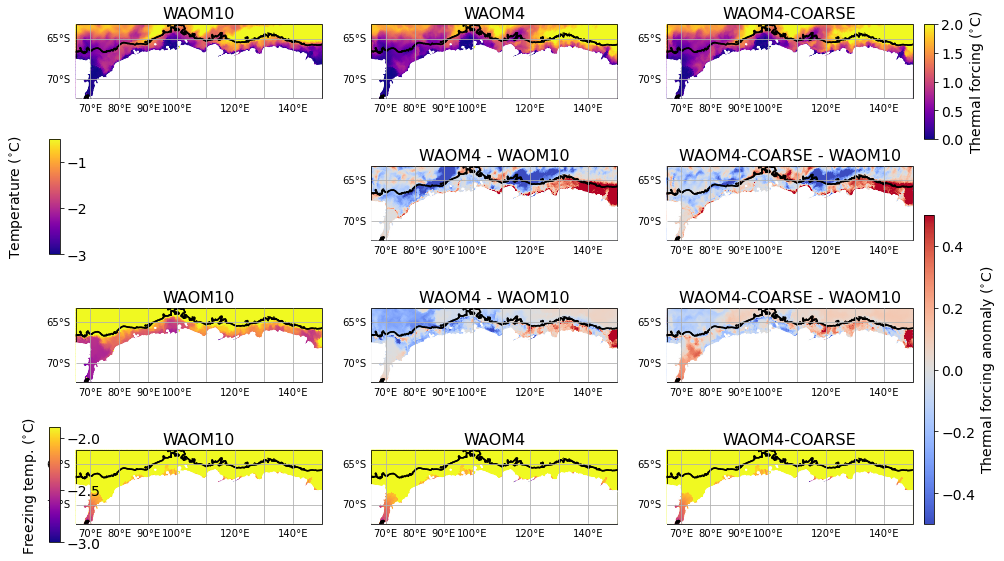

In [15]:
# limits for contour of ice front (East Antarctica):
xlimit = np.arange(250,2500,1)
ylimit = np.arange(2000,3000,1)

proj = ccrs.Mercator()
ratio = .3

# 24.12.2022
# - for thermal forcing comparison b/w resolution, we need to use the same model temp. (e.g. WAOM10) to calculate the
# thermal forcing in a way to see the effect on the freezing temperature. 
# If used each model own temperature (sfc), it shows differences that are related with ocean near-temperature field; 

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(4,3,1, projection=proj)
plt.title('WAOM10', fontsize=16)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_sfc_10 - Tf_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=0, vmax=2)
gl = ax0.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax0.get_xlim()
y_low, y_high = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax0.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax1 = fig.add_subplot(4,3,2, projection=proj)
plt.title('WAOM4', fontsize=16)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_sfc_4 - Tf_sfc_4_interp, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=0, vmax=2)
gl = ax1.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax1.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax2 = fig.add_subplot(4,3,3, projection=proj)
plt.title('WAOM4-COARSE', fontsize=16)
ctf = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_sfc_4c - Tf_sfc_4c_interp, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=0, vmax=2)
gl = ax2.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax2.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax2.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)


ax4 = fig.add_subplot(4,3,5, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_sfc_4 - temp_ann_sfc_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
plt.title('WAOM4 - WAOM10', fontsize=16)
gl = ax4.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax4.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax4.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax5 = fig.add_subplot(4,3,6, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, (temp_ann_sfc_4c - temp_ann_sfc_10), transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
plt.title('WAOM4-COARSE - WAOM10', fontsize=16)
gl = ax5.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax5.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax5.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)

ax6 = fig.add_subplot(4,3,7, projection=proj)
ctf2 = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-3, vmax=-.5)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('WAOM10', fontsize=16)

ax6 = fig.add_subplot(4,3,8, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_4-temp_ann_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('WAOM4 - WAOM10', fontsize=16)

ax6 = fig.add_subplot(4,3,9, projection=proj)
ctfa = plt.pcolormesh(lon_rho_10, lat_rho_10, temp_ann_bot_4c-temp_ann_bot_10, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm, vmin=-.5, vmax=.5)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('WAOM4-COARSE - WAOM10', fontsize=16)

ax6 = fig.add_subplot(4,3,10, projection=proj)
ctf3 = plt.pcolormesh(lon_rho_10, lat_rho_10, Tf_sfc_10, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-3, vmax=-1.9)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('WAOM10', fontsize=16)

ax6 = fig.add_subplot(4,3,11, projection=proj)
ctf3 = plt.pcolormesh(lon_rho_4, lat_rho_4, Tf_sfc_4, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-3, vmax=-1.9)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('WAOM4', fontsize=16)

ax6 = fig.add_subplot(4,3,12, projection=proj)
ctf3 = plt.pcolormesh(lon_rho_4, lat_rho_4, Tf_sfc_4c, transform=ccrs.PlateCarree(), cmap=plt.cm.plasma, vmin=-3, vmax=-1.9)
gl = ax6.gridlines(zorder=4,draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.rotate_labels = False
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
gl.ylocator = mticker.FixedLocator(np.arange(-55,-80,-5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax6.set_extent([65, 150, -72, -63], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax6.add_feature(cfeature.LAND, zorder=3, facecolor='white') # edgecolor='white',
plt.contour(lon_rho_2[xlimit,ylimit], lat_rho_2[xlimit,ylimit],h_2[xlimit,ylimit],levels=(2000,2001), transform=ccrs.PlateCarree(), colors='k',linewidth=1)
plt.title('WAOM4-COARSE', fontsize=16)

## set colorbar
cbar_ax2 = fig.add_axes([0.91, 0.69, 0.01, 0.16])
fig.colorbar(ctf, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Thermal forcing ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax2.tick_params(labelsize=14)

## set colorbar
cbar_ax4 = fig.add_axes([0.1, 0.53, 0.01, 0.16])
fig.colorbar(ctf2, cax=cbar_ax4, orientation='vertical')
cbar_ax4.set_ylabel('Temperature ($^{\circ}$C)', fontsize=14, labelpad=-80)
cbar_ax4.tick_params(labelsize=14)

cbar_ax5 = fig.add_axes([0.1, 0.13, 0.01, 0.16])
fig.colorbar(ctf3, cax=cbar_ax5, orientation='vertical')
cbar_ax5.set_ylabel('Freezing temp. ($^{\circ}$C)', fontsize=14, labelpad=-80)
cbar_ax5.tick_params(labelsize=14)

cbar_ax3 = fig.add_axes([0.91, 0.155, 0.01, 0.43])
fig.colorbar(ctfa, cax=cbar_ax3, orientation='vertical')
cbar_ax3.set_ylabel('Thermal forcing anomaly ($^{\circ}$C)', fontsize=14)#, labelpad=-35)
cbar_ax3.tick_params(labelsize=14)

name_fig="waom10x4x4c_icedraft_thermalfrc_decom_comparison.png"
plt.savefig(fig_path + name_fig, dpi=300, bbox='tight')
plt.show()